In [1]:
import csv
import gzip
import logomaker
import numpy as np
import pandas as pd
import torch
from captum.attr import DeepLift, Saliency
from captum.attr import visualization as viz
from torch.utils.data import DataLoader
import attributes_functions
from attributes_functions import seqtopad, Chip_test, shift_list, shift, MixtureOfExperts, \
    run_moe, attribute_image_features, returnGradPred, returnGradPredMoE, GetAttShiftSmooth, \
        create_logo, create_motif, seq_to_string, string_to_seq

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/nielseni6/miniconda3/envs/dattri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
# from refactor import ConvNet
# from refactor.dataset import chipseq_dataset
from model import ConvNet
from data import chipseq_dataset

# index 284 has example of GATAA and ATC (looking for TTATC)
# seed 2 highlights GATAA
# seed 3 highlights ATC and GATAA

# index 285 has example of GATAA 
# index 286 has example of TTATC 
# index 287 has example of GATAA 
# index 288 has example of TTATC seed 4 highlights a second ATC for ShiftSmooth that is missed without the method
# index 291 has example of TTATC and shows decent results for ShiftSmooth

seed = 42 # 42 was used for training
set_index = 293

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data_path = "data/encode"
chipseq_test = Chip_test(
    f"{data_path}/GATA1_K562_GATA-1_USC_B.seq.gz"
)
test_data = chipseq_test.openFile()
test_dataset = chipseq_dataset(test_data)
batchSize = test_dataset.__len__()
# print(batchSize)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        
gataa_seq, ttatc_seq = create_motif("GATAA", include_reverse=True)
gataa_seq, ttatc_seq = gataa_seq.to(device), ttatc_seq.to(device)
motifs = ["GATAA", "TTATC"]

# print(data[set_index][:,25:30])
seq = seq_to_string(data[set_index])
print(seq)

# print(motifs[0] in seq)
for motif in motifs:
    if motif in seq:
        print(f"{motif} found")

TGCTACATGAATGGATTAATTCCGTTACAGTGGGAGTGGATTTGTTATCTCGGGAGCAGGTTACTGATAAAAGGATGGGTTCCGCCTCCTTCAGCGCTCTC
GATAA found
TTATC found


## Load Trained Model

In [3]:
# from main import load_model
print("Loading model...")

motifs = ["ARID3A", "FOXM1", "GATA3"]
save_path = "/home/nielseni6/PythonScripts/TFBS/weights/moe"
params = [torch.load(f"{save_path}/best_config_{motifs[i]}.pth") for i in range(3)]
# best_hyperparameters = torch.load(f"{save_path}/best_hyperparameters_{0}.pth")
# print("best_hyperparameters: ", params)

configs = []
for best_hyperparameters in params:
    config = {
        "nummotif": 16,
        "motiflen": 24,
        "poolType": best_hyperparameters["poolType"],
        "sigmaConv": best_hyperparameters["sigmaConv"],
        "dropprob": best_hyperparameters["dropprob"],
        "learning_rate": best_hyperparameters["learning_rate"],
        "momentum_rate": best_hyperparameters["momentum_rate"],
        "num_features": 32,
        "d_model": 32,
        "num_heads": best_hyperparameters["num_heads"],
        "dim_feedforward": best_hyperparameters["dim_feedforward"],
        "encoder_dropout": best_hyperparameters["encoder_dropout"],
        "num_layers": best_hyperparameters["num_layers"],
    }
    configs.append(config)

individual_models = [ConvNet(configs[i]).to(device) for i in range(len(configs))]

model_paths = [f"{save_path}/best_model_{motifs[i]}.pth" for i in range(len(motifs))]
checkpoints = [torch.load(model_paths[i]) for i in range(len(model_paths))]

nets = [individual_models[i] for i in range(len(individual_models))]
for i, net in enumerate(nets):
    net.load_state_dict(checkpoints[i])



Loading model...


In [4]:
import torch.nn as nn
import torch.nn.functional as F

moe_model = MixtureOfExperts(num_experts=len(nets), embedding_size=32).to(device)
checkpoint = torch.load(f"{save_path}/moe_model.pth")
moe_model.load_state_dict(checkpoint)

# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]


## Generate Attribution Maps

In [5]:
import warnings

original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

print("Generating Vanilla attributions...")
saliency = Saliency(net)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grads = saliency.attribute(data)
grads = grads.squeeze().detach().cpu().numpy()

dl = DeepLift(net)
net.zero_grad()
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    attr_dl = attribute_image_features(dl, data, baselines=data * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (0, 1, 2))

# print(grads.shape, attr_dl.shape, original_image.shape)

index = np.random.randint(0, grads.shape[0])
while target[index][0] == 0:
    index = np.random.randint(0, grads.shape[0])
index = set_index

# print(index)
grads = grads[index]
original_image = original_image[index]
attr_dl = attr_dl[index]

# print("original_image.shape: ", original_image.shape, "data.shape: ", data.shape)
mask = (data[index,:] != 0.25)[0].cpu()
# print("mask.shape: ", mask.shape)
image_nopad_ = original_image[:,mask]
shape_nopad = image_nopad_.shape
image_nopad = image_nopad_.reshape(shape_nopad[0], shape_nopad[1], 1)
shape = original_image.shape

# print(grads.shape, attr_dl.shape, original_image.shape)
grads = grads.reshape(shape[0], shape[1], 1)
attr_dl = attr_dl.reshape(shape[0], shape[1], 1)
original_image = original_image.reshape(shape[0], shape[1], 1)
# print(grads.shape, attr_dl.shape, original_image.shape)

Generating Vanilla attributions...


## ShiftSmooth

pred: tensor([[0.9384]], device='cuda:0', grad_fn=<SigmoidBackward0>) pred_moe: tensor([[0.4678]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Generating ShiftSmooth attributions...


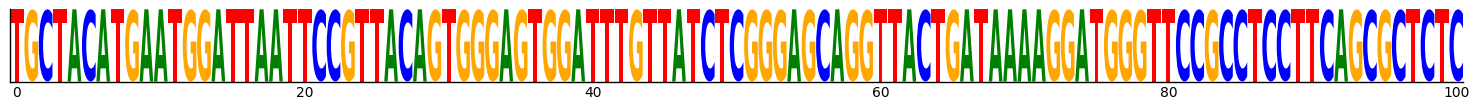

In [6]:
dat = torch.tensor(np.transpose(original_image, (2, 0, 1)), dtype = torch.float32).to(device)
dat_nopad = torch.tensor(np.transpose(image_nopad, (2, 0, 1)), dtype = torch.float32).to(device)
shp = dat.shape

############################### Choose Model (Not MoE) ###############################
# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]
model = net 

########################## SET PARAMETERS FOR ATTRIBUTIONS ##########################
# only show the most important nucleotide
max_only = False 
# absolute value of attribution
magnitude = False 
# only show letters corresponding to actual sequence (will be true for paper results)
original_sequence_only = True 
relu = False
begin_shift = 1
end_shift = 20 #100
shift_increment = 2#7#15
figsize = [50, 8]
figscale = 0.375
figsize = [f * figscale for f in figsize]
#####################################################################################

sequence = original_image if original_sequence_only else 1
data_ = data[index].unsqueeze(0).clone().detach()

################################# Get Predictions ##################################
pred = model(data_)
pred_moe = run_moe(data_, moe_model, nets, softmax=True)
print("pred:", torch.sigmoid(pred), "pred_moe:", pred_moe)
print("Generating ShiftSmooth attributions...")
################################### SINGLE MODEL ###################################
grads = returnGradPred((data_).clone().detach().to(dtype=torch.float32).to(device), 
                       magnitude=magnitude, max_only=max_only, net = model, relu=relu
                       )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence

attr_shiftsmooth = GetAttShiftSmooth(dat_nopad, nshiftlr=1, magnitude=magnitude, max_only=max_only, 
                                     net = model, mask = mask, og_img = data_, device = device, relu=relu
                                     ).reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
# print("original_image.shape: ", original_image.shape, "dat_nopad.shape: ", dat_nopad.shape, "data_.shape: ", data_.shape)
# print(data_[:,:,25:30])

crp_df_original_logo = create_logo(original_image[:,mask], figsize=[figsize[0], figsize[1] * (5/16)], remove_y_axis_numbers=True)

attr_shiftsmooths = [(GetAttShiftSmooth(dat_nopad, nshiftlr=i, magnitude=magnitude, max_only=max_only, 
                                        net = model, mask = mask, og_img = data_, device = device, relu=relu
                     ).reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(begin_shift, end_shift, shift_increment)]
####################################################################################
#################### MoE Model (individual experts attribution) ####################
datas = [data_.clone().detach() for _ in range(len(nets))]
gate_scaling = False

moe_grad = returnGradPredMoE(datas, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets, gate_scaling=gate_scaling, relu=relu
                          )[0]
moe_grads_separate = [(gd.reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence) for gd in moe_grad]
####################################################################################
##################### MoE Model total forward pass attribution #####################
moe_grad = returnGradPredMoE(data_, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets, relu=relu, gate_scaling=gate_scaling
                          )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
# print(moe_grad.shape)
moe_shiftsmooths = [(GetAttShiftSmooth(dat_nopad, net = nets, nshiftlr=i, magnitude=magnitude, max_only=max_only, 
                     moe_model=moe_model, mask = mask, og_img = data_, device = device, relu=relu, gate_scaling=gate_scaling)
                     .reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(begin_shift, end_shift, shift_increment)]
####################################################################################
# print("pred:", torch.sigmoid(pred), "pred_moe:", pred_moe)


## Plot

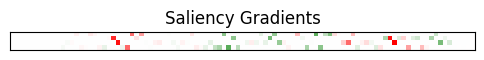

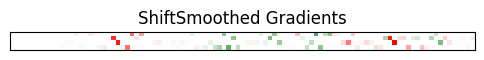

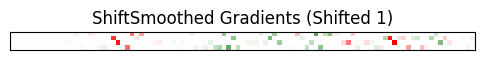

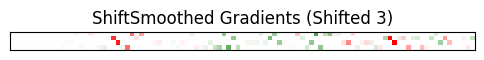

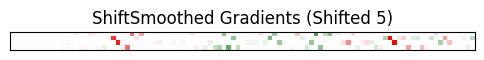

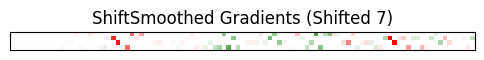

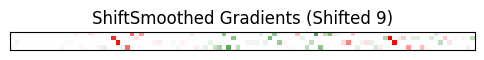

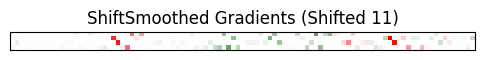

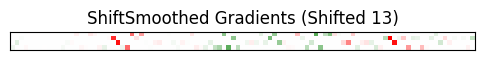

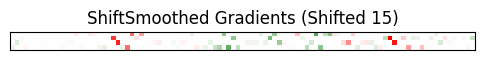

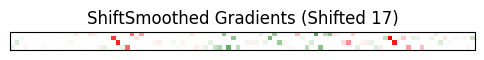

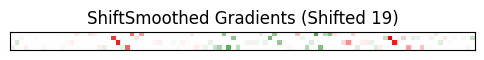

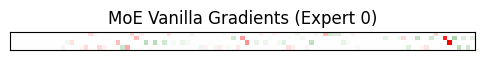

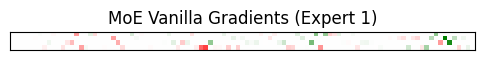

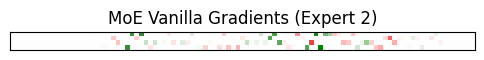

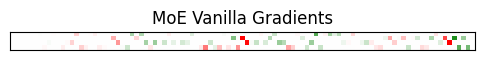

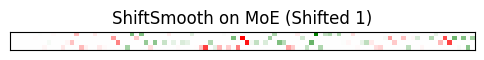

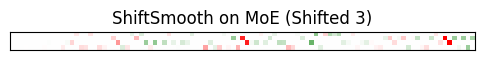

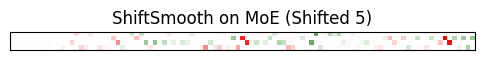

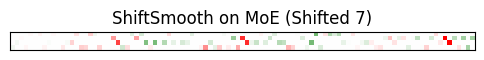

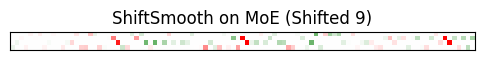

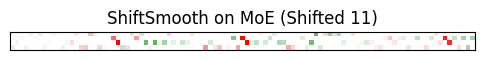

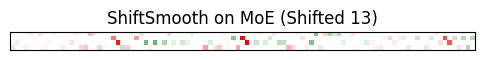

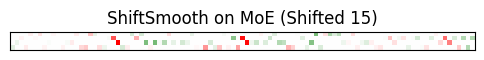

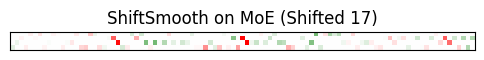

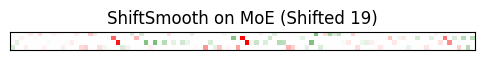

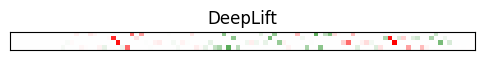

In [7]:
include_pad = False
if include_pad:
    mask[:,:] = True

# _ = viz.visualize_image_attr(
#     None,
#     original_image,
#     method="original_image",
#     title="Original Sequence | Prediction {}".format(target[index][0]),
# )
################################### SINGLE MODEL ###################################
_ = viz.visualize_image_attr(
    grads[:,mask], original_image[:,mask], method="heat_map", sign="all", title="Saliency Gradients"
)

_ = viz.visualize_image_attr(
    attr_shiftsmooth[:,mask], original_image[:,mask], method="heat_map", sign="all", title="ShiftSmoothed Gradients"
)

for attr_shiftsmooth2, i in attr_shiftsmooths:
    _ = viz.visualize_image_attr(
        attr_shiftsmooth2[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"ShiftSmoothed Gradients (Shifted {i})"
    )

####################################################################################

#################### MoE Model (individual experts attribution) ####################

for i, moe_grad_ in enumerate(moe_grads_separate):
    _ = viz.visualize_image_attr(
        moe_grad_[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"MoE Vanilla Gradients (Expert {i})"
    )
####################################################################################
##################### MoE Model total forward pass attribution #####################
_ = viz.visualize_image_attr(
    moe_grad[:,mask], original_image[:,mask], method="heat_map", sign="all", title="MoE Vanilla Gradients"
)

for moe_shiftsmooth, i in moe_shiftsmooths:
    _ = viz.visualize_image_attr(
        moe_shiftsmooth[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"ShiftSmooth on MoE (Shifted {i})"
    )
####################################################################################

_ = viz.visualize_image_attr(
    attr_dl[:,mask], original_image[:,mask], method="heat_map", sign="all", title="DeepLift"
)


## Motifs

Original Sequence
Vanilla Gradients


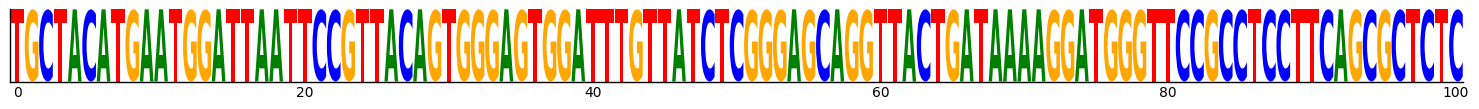

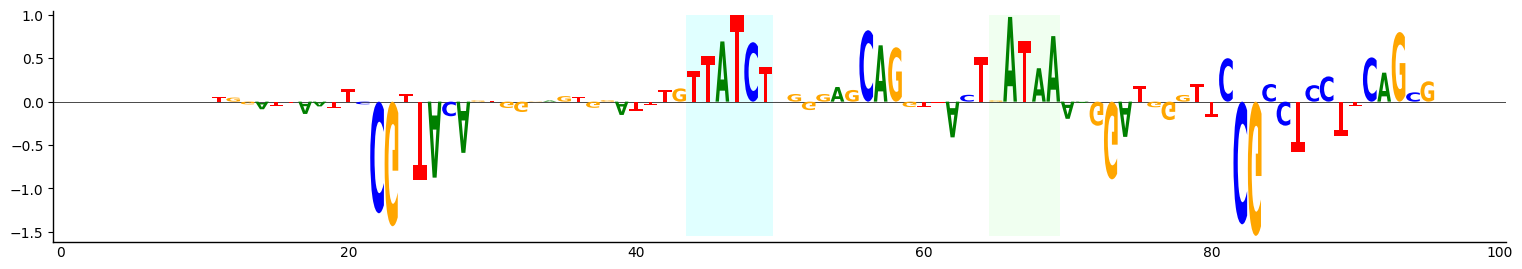

In [8]:
scale_data = False
show_all = False

# Create logos for each dataset
print("Original Sequence")
crp_df_original_logo = create_logo(original_image[:,mask], figsize=[figsize[0], figsize[1] * (5/16)], xlims=[-0.5,100.5], remove_y_axis_numbers=True)

if not show_all:
    attr_shiftsmooths = attr_shiftsmooths[:1]
    moe_shiftsmooths = moe_shiftsmooths[:1]

# Calculate max and min values for attr_shiftsmooth[:,mask]
attr_shiftsmooth_max, attr_shiftsmooth_min = attr_shiftsmooth[:,mask][:,:99].max(), attr_shiftsmooth[:,mask][:,:99].min()
# Calculate max and min values for grads[:,mask]
grads_max, grads_min = grads[:,mask][:,:99].max(), grads[:,mask][:,:99].min()
# Store mins and maxes in lists
    
mins = [attr_shiftsmooth2[:,mask][:,:99].min() for attr_shiftsmooth2, i in attr_shiftsmooths] + [attr_shiftsmooth_min, grads_min]
maxes = [attr_shiftsmooth2[:,mask][:,:99].max() for attr_shiftsmooth2, i in attr_shiftsmooths] + [attr_shiftsmooth_max, grads_max]

ymin = min(mins)
ymax = max(maxes)
ylims = [ymin, ymax]

print("Vanilla Gradients")
crp_logo = create_logo(grads[:,mask], figsize=figsize, scale_data=scale_data, ylims=ylims, xlims=[-0.5,100.5], highlight_range1=[44, 49], highlight_range2=[65, 69])
# print("Vanilla Gradients")
# vg_crp_logo = create_logo(vanilla_grads, figsize=figsize, scale_data=True)
# print("pred:", torch.sigmoid(pred), "pred_moe:", pred_moe)

ShiftSmoothed Gradients (Shifted 1)


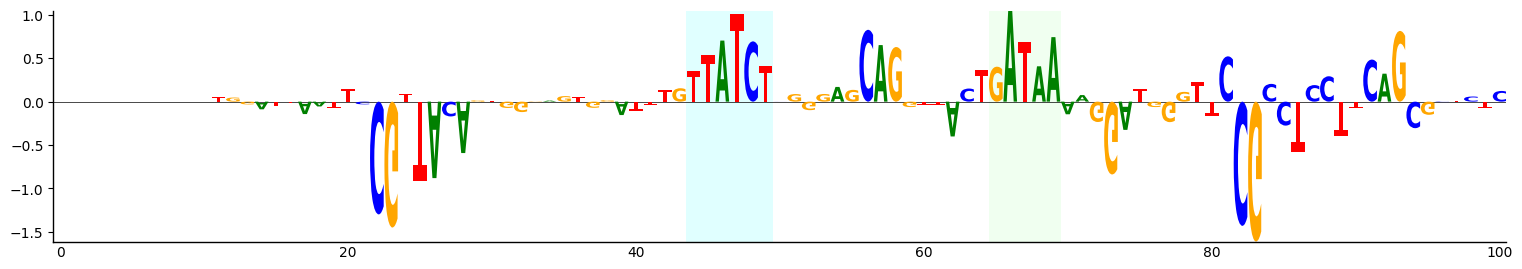

In [9]:
# print("ShiftSmoothed Gradients")
# shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth[:,mask], figsize=figsize, scale_data=scale_data, ylims=ylims)

for attr_shiftsmooth2, i in attr_shiftsmooths:
    print(f"ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth2[:,mask], figsize=figsize, scale_data=scale_data, ylims=ylims, highlight_range1=[44, 49], highlight_range2=[65, 69])



---

In [10]:
# Calculate max and min values for grads[:,mask]
grads_max, grads_min = moe_grad[:,mask][:,:99].max(), moe_grad[:,mask][:,:99].min()
# Store mins and maxes in lists
mins = [attr_shiftsmooth2[:,mask][:,:99].min() for attr_shiftsmooth2, i in moe_shiftsmooths] + [grads_min,]
maxes = [attr_shiftsmooth2[:,mask][:,:99].max() for attr_shiftsmooth2, i in moe_shiftsmooths] + [grads_max,]

ymin = min(mins)
ymax = max(maxes)
ylims = [ymin, ymax]

MoE Vanilla Gradients


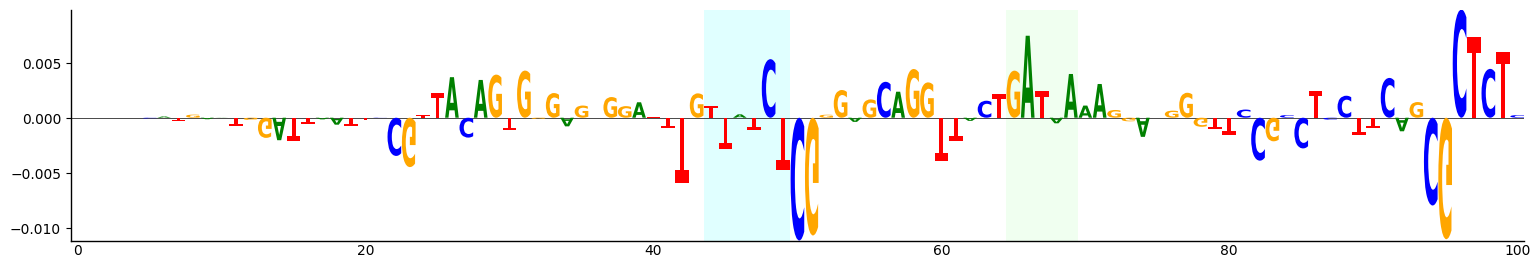

In [14]:
print("MoE Vanilla Gradients")
moe_crp_df_logo = create_logo(moe_grad[:,mask], figsize=figsize, scale_data=scale_data, ylims=ylims, highlight_range1=[44, 49], highlight_range2=[65, 69])
# print("MoE 2 Vanilla Gradients")
# moe_crp_df_logo = create_logo(moe_grad_, figsize=figsize, scale_data=scale_data)


MoE ShiftSmoothed Gradients (Shifted 1)


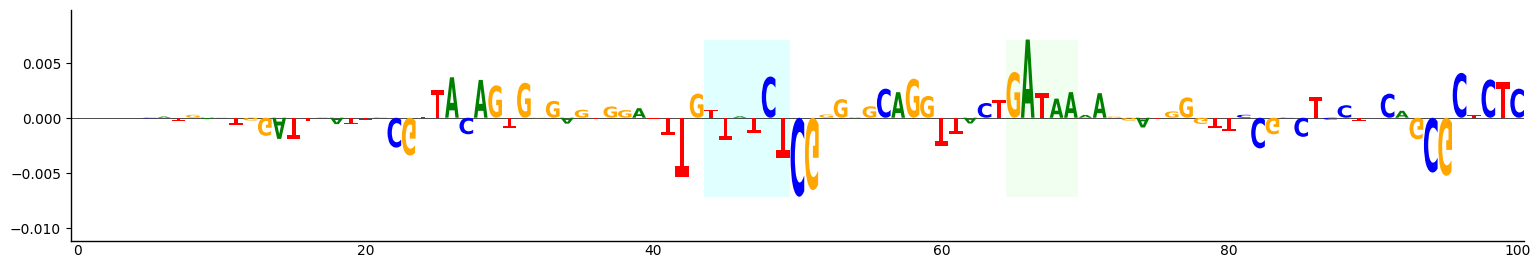

In [15]:

for moe_shiftsmooth, i in moe_shiftsmooths:
    print(f"MoE ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_moe_df_logo = create_logo(moe_shiftsmooth[:,mask], figsize=figsize, scale_data=scale_data, ylims=ylims, highlight_range1=[44, 49], highlight_range2=[65, 69])

In [13]:
# print("DeepLIFT")
# dl_crp_df_logo = create_logo(attr_dl[:,mask], figsize=figsize, scale_data=scale_data)